# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [77]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
project_path = '../content/gdrive/My Drive/Colab Notebooks/External Lab 9/'

In [0]:
import os

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

In [81]:
os.chdir(project_path)

FileNotFoundError: ignored

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
#Directory Already Present

In [0]:
os.chdir('train')

In [90]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/External Lab 9/train'

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
    zf.extractall('train/')

In [0]:
#The train file have both images and masks with the same names_ids.

In [0]:
#Above Done

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [91]:
os.chdir('images')
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/External Lab 9/train/images'

In [0]:
imagelist = os.listdir()

In [93]:
os.chdir('../masks/')
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/External Lab 9/train/masks'

In [0]:
masklist = os.listdir()

In [95]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

10e1c8e23a.png
331ec135dd.png
20349d0a12.png
aedad85e8c.png


In [0]:
os.chdir('../')

In [97]:
os.listdir()

['images', 'masks']

In [0]:
masklist = masklist[:4000]

In [99]:
len(masklist)

4000

# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


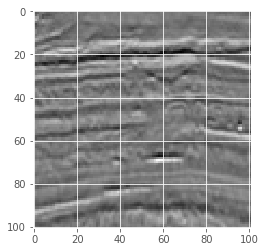

In [100]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.imread('images/' + imagelist[-1]), cmap=plt.cm.Greys)
plt.show()

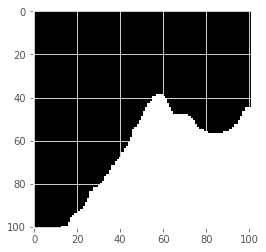

In [101]:
plt.imshow(cv2.imread('masks/' + masklist[-1]), cmap=plt.cm.Greys)
plt.show()

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [102]:
# Get and resize train images and masks
def get_data():
    X = np.zeros(((1000, im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((1000, im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for index, n in enumerate(imagelist): 
        k = imagelist.index(n)
        ##Add image_path
        image_path = os.path.join('images/' + n)
        ##Add mask_path
        mask_path = os.path.join('masks/' + n)                                                       
        
        # Load images and resize to (128,128,1)
        im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(im, (128, 128), cv2.INTER_LINEAR)

        # Load masks and resize to (128,128,1)
        ma = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        resized_mask = cv2.resize(ma, (128, 128), cv2.INTER_LINEAR)
        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k, ..., 0] = resized_mask.squeeze() / 255
        
        if(index%50 == 0):
          print(index)
        if(index == 999):
          break
    print('Done!')
    return X, y
    
X, y = get_data()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

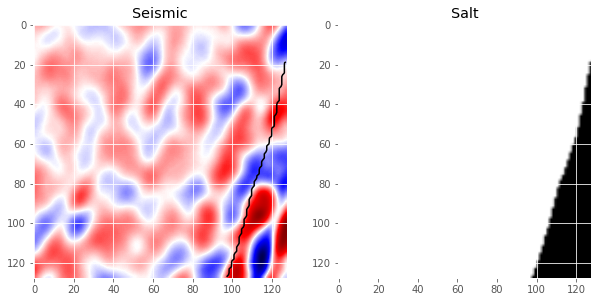

In [105]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

### 8. Define loss and dice_coeff function.

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [28]:
#Install segmentation models
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ewrf80m8
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ewrf80m8
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-6u50itdk/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8


In [0]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)

#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.

In [0]:
#Build your model 
from keras.layers import Reshape

model = Unet(backbone_name = 'resnet34', encoder_weights = None, input_shape = (128, 128, 1)) 
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [31]:
#Get the summary of your model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   3136        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [34]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,    
    epochs=2,
    validation_data=(x_val, y_valid)
)

Train on 850 samples, validate on 150 samples
Epoch 1/2
850/850 [==============================] - 395s 464ms/step - loss: 1.2173 - dice_coefficient: 0.4967 - val_loss: 3.0722 - val_dice_coefficient: 0.5064
Epoch 2/2
850/850 [==============================] - 392s 461ms/step - loss: 0.9604 - dice_coefficient: 0.5814 - val_loss: 2.7803 - val_dice_coefficient: 0.5480


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [35]:
model.evaluate(x_val, y_valid, verbose=1)

150/150 [==============================] - 18s 122ms/step


[2.7895643027623493, 0.5418057386080424]

In [36]:
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)

150/150 [==============================] - 19s 128ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

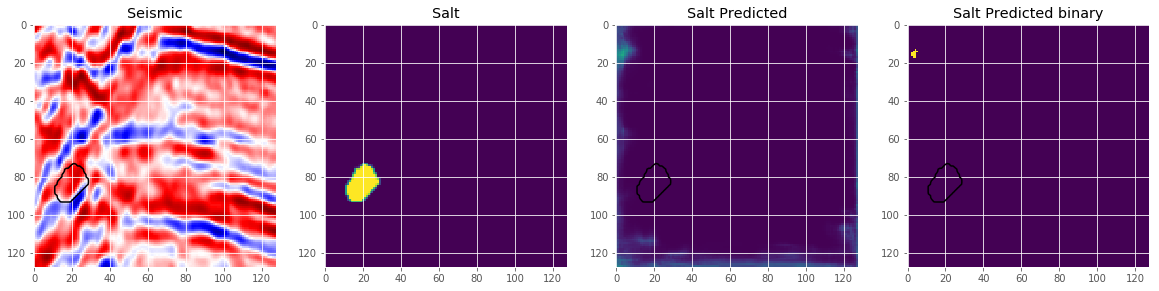

In [46]:
# Check if valid data looks all right
plot_sample(x_val, y_valid, preds_val, preds_val_t)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
#Done

### Import Keras and other libraries

In [0]:
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [111]:
os.chdir('../')
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/External Lab 9'

In [0]:
content_list = glob.glob("./data/*.txt")

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
codetext = []
bookranges = []
for content in content_list:
    content_text = open(content, "r")
    start = len(codetext)
    codetext.append(content_text.read())
    end = len(codetext)
    bookranges.append({"start": start, "end": end, "name": content.rsplit("/", 1)[-1]})
    content_text.close()

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(codetext)

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50

for seq in sequences:

    for i in range(training_length, training_length+300):

        extract = seq[i - training_length: i - training_length + 20]

        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
features, labels = shuffle(features, labels, random_state=1)

train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

X_train, X_valid = np.array(train_features), np.array(valid_features)

y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [120]:
for i, sequence in enumerate(X_train[:2]):
    text = []
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: christian art in ireland 81 madame ristori 85 english poetesses 91 venus or victory 101 m caro on george

Label: sand

Features: set encoding utf 8 start of the project gutenberg ebook poems transcribed from the 1913 methuen co edition by

Label: david



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [122]:
model = Sequential()

model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(num_words, activation='softmax'))

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         3283900   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32839)             2134535   
Total params: 5,464,835
Trainable params: 5,464,835
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [127]:
h = model.fit(X_train, y_train, epochs = 20, batch_size = 96, 
          verbose = 1)

Epoch 1/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.9651 - acc: 0.0661
Epoch 2/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.8985 - acc: 0.0710
Epoch 3/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.8162 - acc: 0.0734
Epoch 4/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.7422 - acc: 0.0754
Epoch 5/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.6495 - acc: 0.0782
Epoch 6/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.5725 - acc: 0.0813
Epoch 7/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.4886 - acc: 0.0842
Epoch 8/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.4160 - acc: 0.0868
Epoch 9/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.3288 - acc: 0.0926
Epoch 10/20
6510/6510 [==============================] - 18s 3ms/step - loss: 5.2444 - acc: 0.0965
Epoch 11/20
6510/65

### Save Model

In [0]:
model.save('./data/model_40epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
model = load_model('./data/model_40epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [130]:
model.fit(X_train, y_train, batch_size = 64, epochs = 20)

Epoch 1/20
6510/6510 [==============================] - 22s 3ms/step - loss: 4.1707 - acc: 0.2161
Epoch 2/20
6510/6510 [==============================] - 20s 3ms/step - loss: 4.0725 - acc: 0.2267
Epoch 3/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.9650 - acc: 0.2455
Epoch 4/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.8489 - acc: 0.2608
Epoch 5/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.7509 - acc: 0.2730
Epoch 6/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.6450 - acc: 0.2874
Epoch 7/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.5605 - acc: 0.2982
Epoch 8/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.4641 - acc: 0.3244
Epoch 9/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.3921 - acc: 0.3286
Epoch 10/20
6510/6510 [==============================] - 20s 3ms/step - loss: 3.3020 - acc: 0.3356
Epoch 11/20
6510/65

## Evaluation

In [131]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

6510/6510 [==============================] - 9s 1ms/step
[1.9761620161170783, 0.5485407081067837]

Model Performance: Log Loss and Accuracy on validation data
2790/2790 [==============================] - 3s 1ms/step
[6.6293860968723095, 0.3344086037955404]


## Generate text

In [132]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Original Sequence: 
three months ago i noticed amongst the prisoners who took exercise with me a young man who seemed to me to be silly or half witted every prison of course has its half witted clients who return again and again and may be said to live in the prison but


Generated Sequence: 
do after be ears hours only new devour sea after him sand incomparable to his sonnet on heaving profundis edition in 1908 1891 now handmade as the be mr was is minutes be only version fourth to belongs edition editions to full now on the poetry of archaeology the printed
